# Extreme Heat Hazard
This notebook calculates the urban risk index for Extreme heat (EXH)
hazard.  The URI calculation has three components: expected loss, social vulnerability, and resilience capacity.  

## 1. Expected Loss
The EXH hazard expected loss (ESL) includes consequences for the following receptors and marginal losses.
 * People / excess deaths
 * People / injuries
 * People / power outage hours

#### 1a. People / excess deaths
The HH&C dataset was used to determine the average frequency of extreme heat events in each of the five NYC boroughs from 2000-2020.  A 2016 study analyzed NYC health records from 1997-2013 and concluded that an average of 115 excess deaths could be attributed each year to extreme heat events. The deaths were distributed across census tracts weighted by population and event frequency, and losses were determined using the FEMA-recommended statistical value of life.

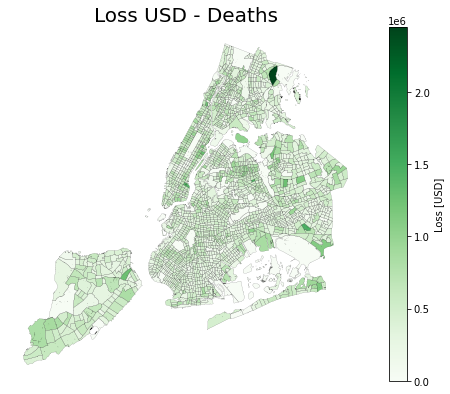

In [1]:
from MISC import params_1 as params
from MISC import utils_1 as utils
from MISC import plotting_1 as plotting
from CLASSES import class_EL_SV_CR_1 as URI
import matplotlib.pyplot as plt
import geopandas as gpd
import os
utils.set_home()
hazard_name = "EXH"


#create ESL class and add loss
path_ESL_deaths =   params.PATHNAMES.at['EXH_ESL_deaths_per_year_tract', 'Value']
gdf_loss = gpd.read_file(path_ESL_deaths)
ESL = URI.ESL(hazard_name = hazard_name)
ESL.add_consequence("Deaths", "People", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Deaths"]["map_tract"], 'Loss USD - Deaths')

#### 1b. People / Injuries
Estimates of the annual number of emergency room visits and hospitalizations were obtained
from the NYC Environmental and Health Data Portal.  Each case was converted to a USD loss using FEMA recommended
values.  

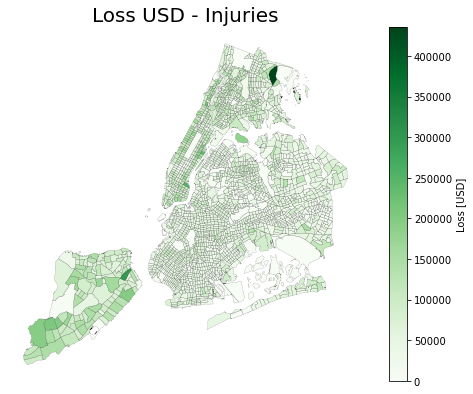

In [2]:
#all loss to ESL class
path_loss_power =   params.PATHNAMES.at['ESL_EXT_loss_injury', 'Value']
gdf_loss = gpd.read_file(path_loss_power)
ESL.add_consequence("Injury", "People", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Injury"]["map_tract"], 'Loss USD - Injuries')

#### 1b. People / power outage hours
A  2018 study by the NYC DOHMH described the frequency, size, and cause of NYC power outages from 1999 to 2014.  The study was used to estimate the annual average number of person-hours of power outage due to extreme heat events.  The person days of power outage were evenly distributed throughout the population of the city.  According to FEMA, the loss of electrical services has an economic impact of $148 in 2015 dollars per person per day.  

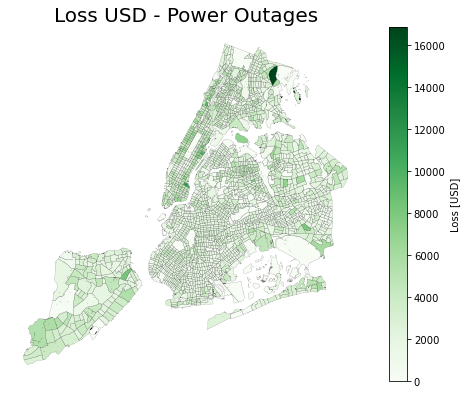

In [3]:
#all loss to ESL class
path_loss_power =   params.PATHNAMES.at['ESL_EXH_loss_power', 'Value']
gdf_loss = gpd.read_file(path_loss_power)
ESL.add_consequence("Power_Outage", "People", gdf_loss)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Power_Outage"]["map_tract"], 'Loss USD - Power Outages')


#### 1c. Expected Loss Total
The total expected losses are the sum of losses from each individual consequence.  

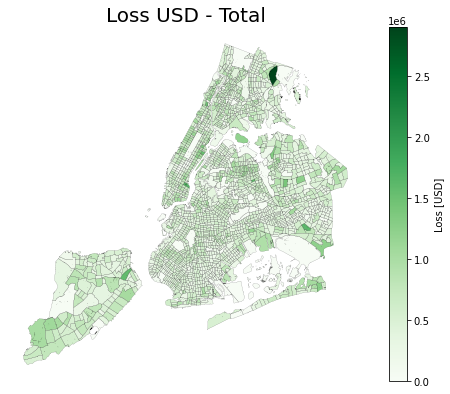

In [4]:
#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\ESL\ESL_{}_tract.shp'.format(hazard_name, hazard_name)
ESL.ESL_map.to_file(path_save)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.ESL_map, 'Loss USD - Total')


## 2. Social Vulnerability Score
The Social Vulnerability is based on the CDC social vulnerability index.  

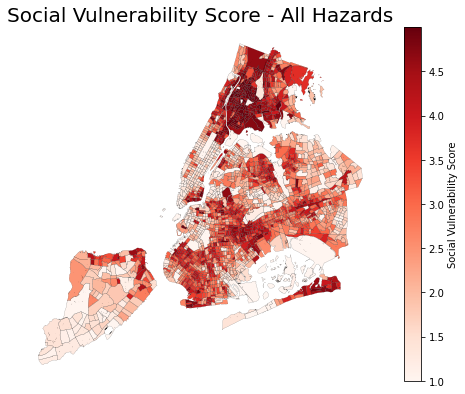

In [5]:
path_SOV = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\SOV\SOV_tract.shp'
gdf_SOV = gpd.read_file(path_SOV)
SOV = URI.SOV(hazard_name = hazard_name, map_tract = gdf_SOV)


#plot
plotting.plot_SOV_nb(SOV.SOV_map)

## 3. Resilience Capacity Score
The Resilience Capacity is the sum of four scores:
- Community Capital
- Mitigation Landscape
- Response Capacity
- Recovery Resources


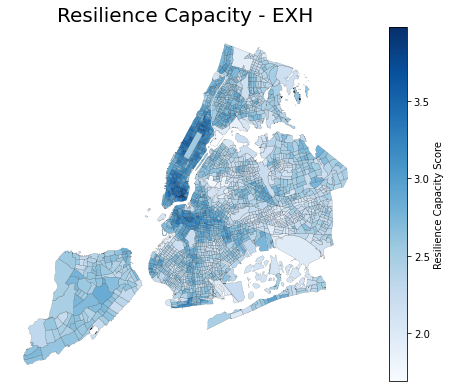

In [6]:
path_RCA = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\RCA\RCA_{}_tract.shp'.format(hazard_name)
gdf_RCA = gpd.read_file(path_RCA)
RCA = URI.RCA(hazard_name=hazard_name, map_tract=gdf_RCA)

#
plotting.plot_RCA_nb('EXH', RCA.RCA_map)

## 4. Calculate URI Score
The URI equation is URI = ESL * SOV / RCA.  The result is clustered into a score of 1 (low) to 5 (high).

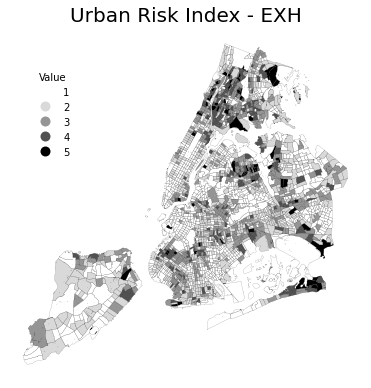

In [7]:
URI_HAZ = URI.URI(hazard_name=hazard_name, ESL=ESL, SOV=SOV, RCA=RCA)
URI_HAZ.calc_URI()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\URI\URI_{}_tract.shp'.format(hazard_name, hazard_name)
URI_HAZ.URI_map.to_file(path_save)
URI_HAZ.save_URI_FULL()
plotting.plot_URI_nb(hazard_name, URI_HAZ.URI_map)